In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
from sklearn import datasets
from scipy.stats import norm
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import matplotlib.colors as colors

In [2]:
class DummyBinaryClassifier:
    def __init__(self,method='bernoulli', p=0.5):
        self.method = method
        self.p= p
    def fit(self,X,y):
        pass
    def predict(self,X):
        if self.method=='bernoulli':
            return np.array(bernoulli.rvs(size=len(X),p=self.p))
        if self.method=='normal':
            return np.array(0.5 + (np.random.randn(len(X))) > self.p)
        if self.method=='uniform':
            return np.array(np.random.rand(len(X)) < self.p)

In [3]:
def areaUnderCurve(x,y):
    '''To find the area under RoC, PRC curves, etc'''
    return sum([0.5*(x[i+1]-x[i])*(y[i+1]+y[i]) for i in range(len(x)-1)])
def visualize_decision_boundary(X, y, model, title="",axis=None):
    '''Helper function to draw decision boundary'''
    # create the x1 and x2 axis as a linear space spawning from the minimum to maximum feature values.
    x1 = X[:,0]
    x2 = X[:,1]
    grid_x1 = np.linspace(x1.min(), x1.max(), 100)
    grid_x2 = np.linspace(x2.min(), x2.max(), 100)
    x1v, x2v = np.meshgrid(grid_x1, grid_x2)
    # create the test dataframe
    test_data = pd.DataFrame(data=np.column_stack((x1v.flatten(), x2v.flatten())), columns=['sepal length (cm)','sepal width (cm)'])
    test_yhat = model.predict(test_data)
    # plot the data
    color_map = colors.ListedColormap(['blue','green'])
    # print(test_yhat)
    if np.sum(test_yhat) == len(test_yhat) :
        color_map = colors.ListedColormap(['green','blue'])
    axis.scatter(x1v, x2v, marker='.', s=2, c=test_yhat, cmap=color_map)
    axis.scatter(x1, x2, marker='.', c=y, cmap=color_map)
    if title != "":
        axis.set_title(title)

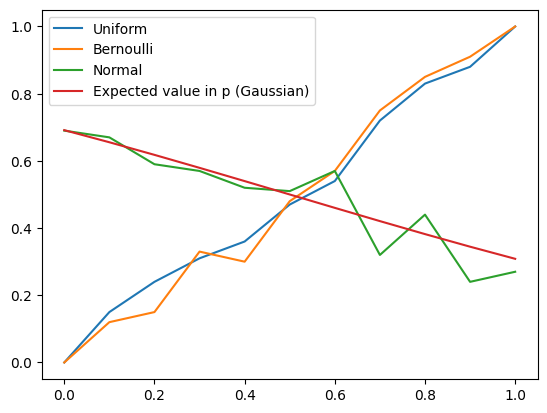

In [4]:
step = 0.1                  # step size for the p values  
n = 100                     # size of feature matrix
X = np.random.rand(n)
p_values = np.arange(0,1+step,step)
n_values = []               
b_values = []
u_values = []
for p in p_values:
    nDummyBinaryClassifier = DummyBinaryClassifier(method='normal',p=p)
    val = (nDummyBinaryClassifier.predict(X)==1).sum()   
    n_values.append(val/(n))    # storing the number of non-zero values with normal as the method
    bDummyBinaryClassifier = DummyBinaryClassifier(method='bernoulli',p=p)
    val = (bDummyBinaryClassifier.predict(X)==1).sum()
    b_values.append(val/(n))    # storing the number of non-zero values with normal as the bernoulli
    uDummyBinaryClassifier = DummyBinaryClassifier(method='uniform',p=p)
    val = (uDummyBinaryClassifier.predict(X)==1).sum()
    u_values.append(val/(n))    # storing the number of non-zero values with normal as the uniform
plt.plot(p_values,u_values,label='Uniform')
plt.plot(p_values,b_values,label='Bernoulli')
plt.plot(p_values,n_values,label='Normal')
plt.plot(p_values,1-norm.cdf(p_values-0.5),label='Expected value in p (Gaussian)')
plt.legend()
plt.show()


In [5]:
iris = datasets.load_iris()     #loading the iris dataset
iris['feature_names']       

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [6]:
X = np.array(iris['data'])
R = []      # Storing recall
P = []      # Storing precsion
FPR = []    # Storing false positive rate
y = np.array(iris['target'])

In [7]:
X, y = shuffle(X,y,random_state=0)
most_frequent_element = np.bincount(y).argmax()
# Class 0 is labelled as 1 rest class 1 and class 2 are labelled as 0
y_modified = [1 if element==most_frequent_element else 0 for element in y ]
for p in p_values:
    dummyClassifier = DummyBinaryClassifier(method='bernoulli',p=p)
    y_prediction = dummyClassifier.predict(X)
    confusionMatrix = confusion_matrix(y_modified,y_prediction).astype('float').T
    if confusionMatrix[1][0] + confusionMatrix[1][1] != 0:
        P.append(confusionMatrix[1][1]/(confusionMatrix[1][0] + confusionMatrix[1][1]))
    else:
        P.append(0)
    R.append(confusionMatrix[1][1]/(confusionMatrix[0][1] + confusionMatrix[1][1]))
    FPR.append(confusionMatrix[1][0]/(confusionMatrix[0][0] + confusionMatrix[1][0]))

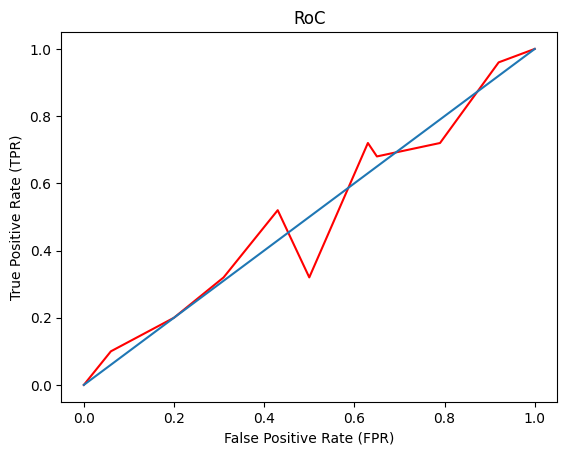

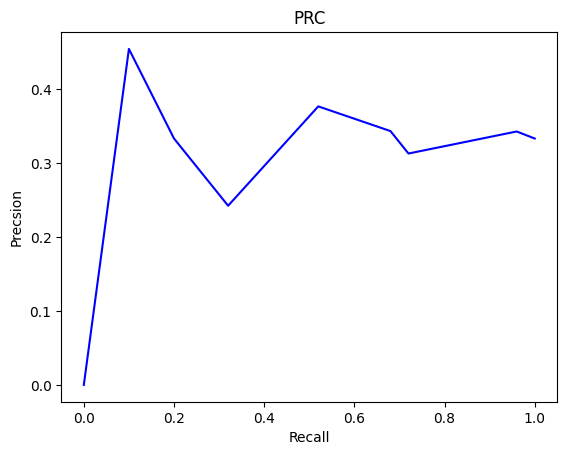

C:\Users\aksha\AppData\Local\Temp\ipykernel_26272\3713388549.py:22: RuntimeWarning: divide by zero encountered in divide
  plt.plot(p_values,((1/np.array(R)+1/np.array(P))*0.5)**(-1),label='F1')


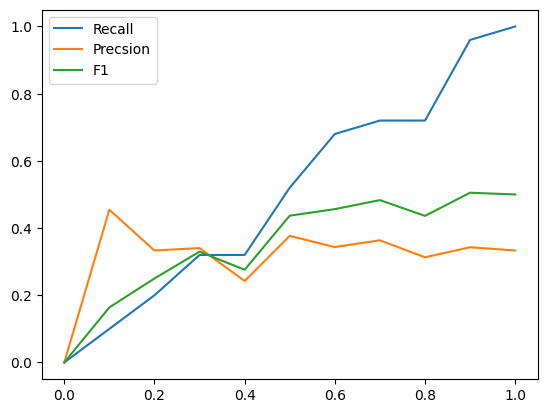

In [8]:
plt.title('RoC')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
dict_of_FPR_P = (dict(zip(FPR,R))) 
keys = sorted(dict_of_FPR_P.keys())
plt.plot(keys,[dict_of_FPR_P[key] for key in keys],'-r',label='RoC')
area_under_roc = areaUnderCurve(keys,[dict_of_FPR_P[key] for key in keys])
plt.plot(p_values,p_values,'-',label='Random Classifier')
plt.show()

plt.title('PRC')
plt.xlabel('Recall')
plt.ylabel('Precsion')
dict_of_R_P = (dict(zip(R,P))) 
keys = sorted(dict_of_R_P.keys())
plt.plot(keys,[dict_of_R_P[key] for key in keys],'-b')
area_under_prc = areaUnderCurve(keys,[dict_of_R_P[key] for key in keys])
plt.show()

plt.plot(p_values,R,label='Recall')
plt.plot(p_values,P,label='Precsion')
plt.plot(p_values,((1/np.array(R)+1/np.array(P))*0.5)**(-1),label='F1')
plt.legend()
plt.show()

In [9]:
print("Area under RoC: " +str(area_under_roc))
print("Area under PRC: " +str(area_under_prc))

Area under RoC: 0.49960000000000004
Area under PRC: 0.3215713658322354


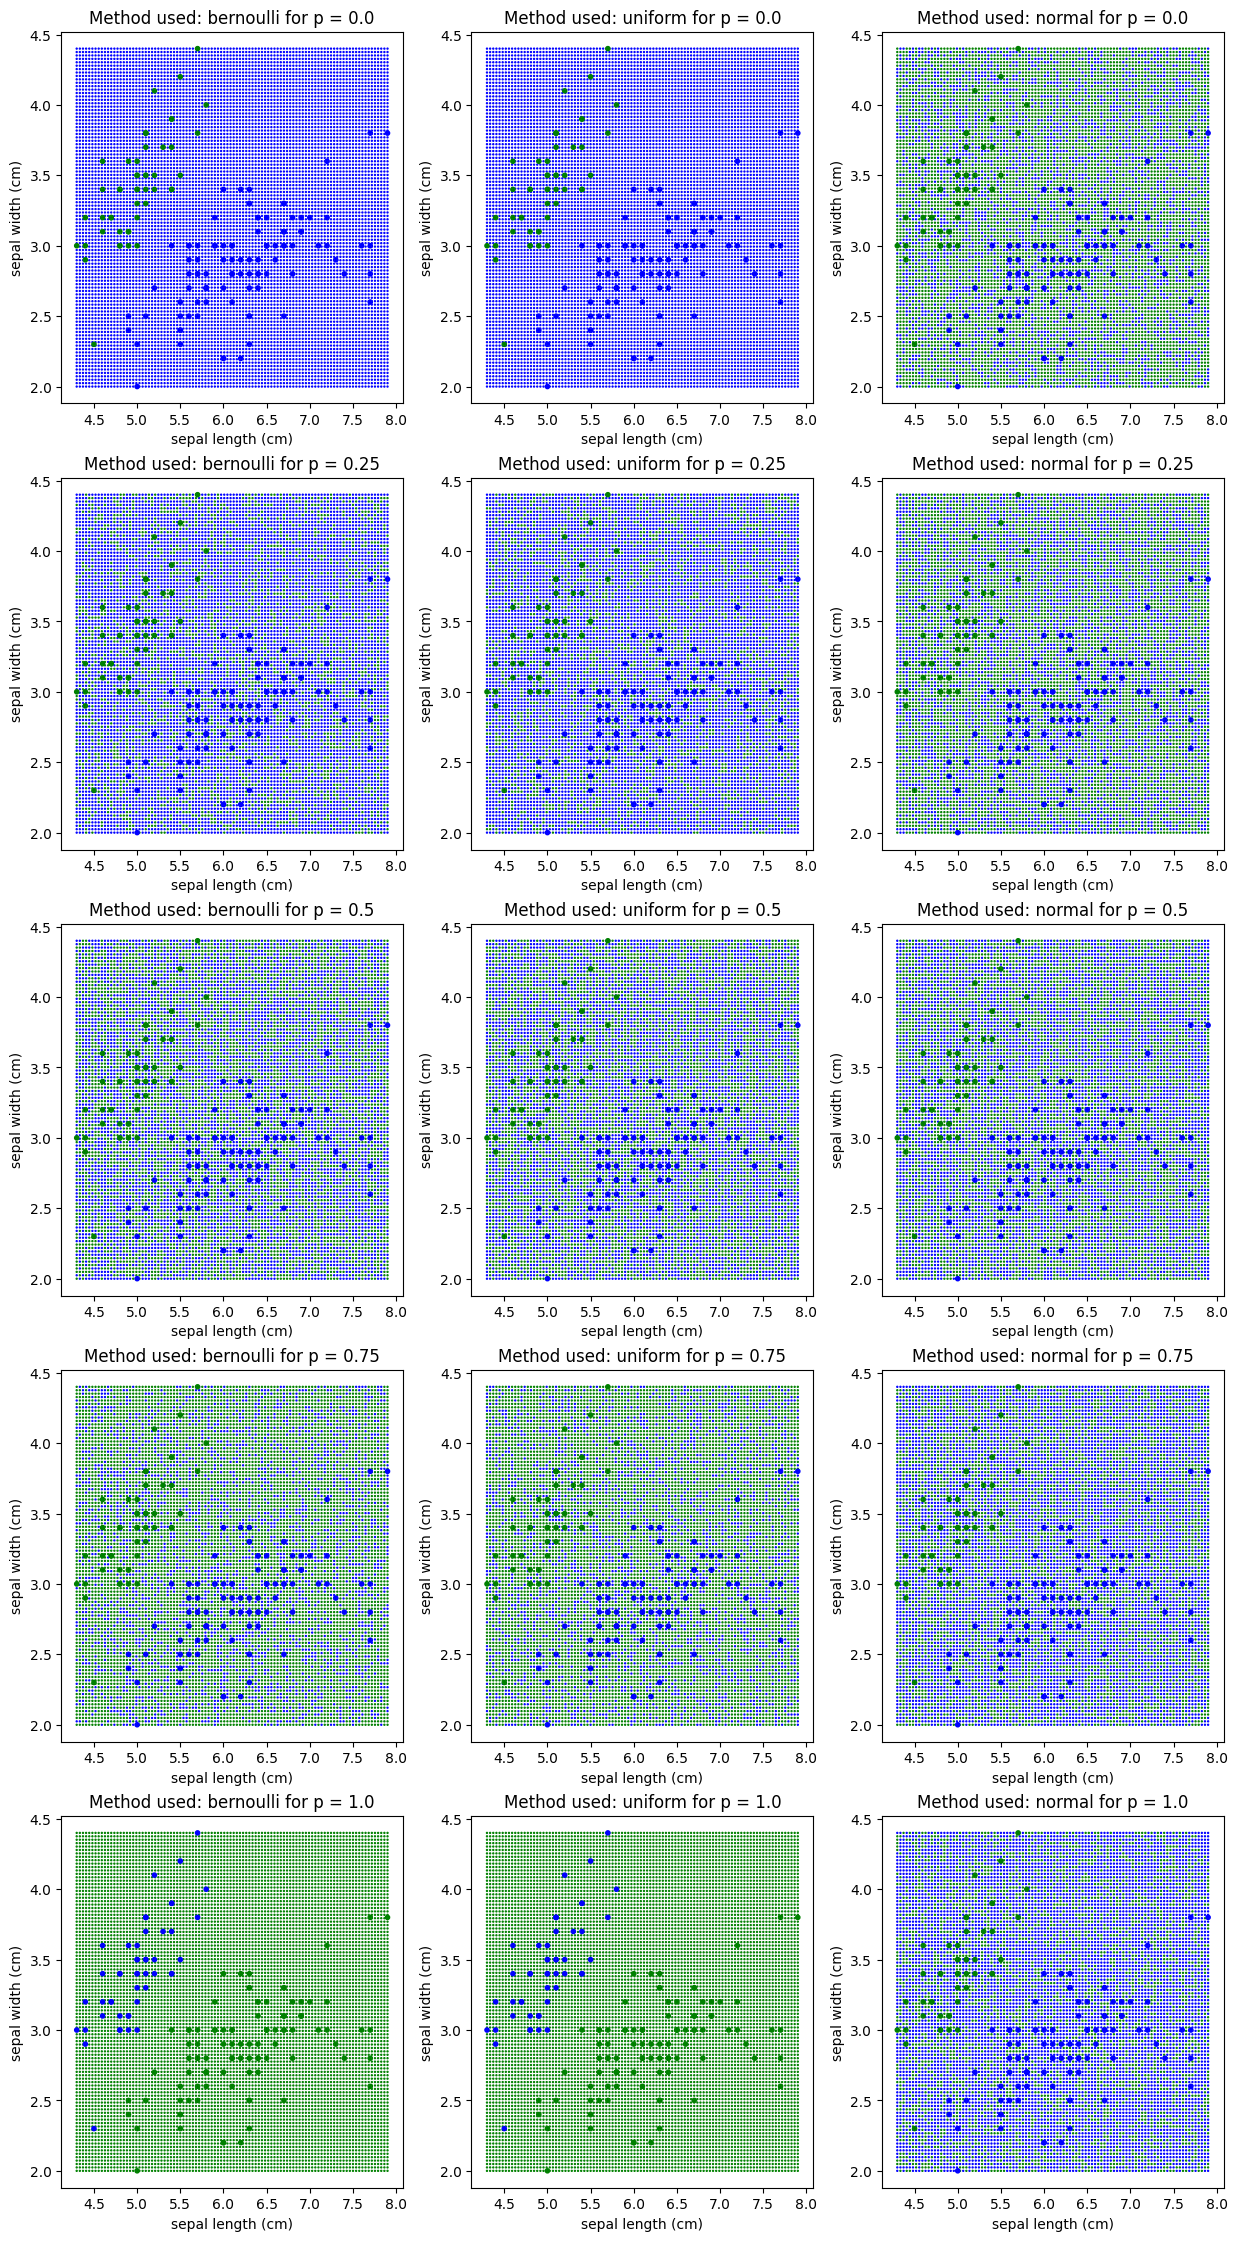

In [10]:
# visualization of the decision boundaries induced by DummyBinaryClassifier at different values of p 
fig, axs = plt.subplots(5, 3, figsize=(15, 28))
j = 0 
for p in np.arange(0,1.25,.25):
    i = 0
    for method in ['bernoulli','uniform','normal']:
        dummyClassifier = DummyBinaryClassifier(method=method,p=p)
        visualize_decision_boundary(X, y_modified, dummyClassifier,title='Method used: '+str(method)+' for p = '+str(p),axis = axs[j,i])
        axs[j,i].set_xlabel('sepal length (cm)')
        axs[j,i].set_ylabel('sepal width (cm)')
        i += 1
    j += 1